In [40]:
import numpy as np
import time
import pandas as pd 
import matplotlib.pyplot as plt
import math 
import random
import scipy.io as spio
import collections
from sklearn.model_selection import train_test_split

columns = ['coluna 1', 'coluna 2']
train = pd.read_csv("cluster.dat", decimal=".", sep=' ', names=columns)
eps = 0.005
minpts = 10

In [41]:
def normalize(data):
  normData = data.copy()
  for i in range(data.shape[1]):
    normData.iloc[:,i] /= np.linalg.norm(data.iloc[:,i])
  return normData

In [42]:
def split_dataset(data, p=0.9): 
  embaralhado = data.iloc[np.random.permutation(len(data))]
  d1 = embaralhado.iloc[0:int(embaralhado.shape[0]*p),:]
  d2 = embaralhado.iloc[int(embaralhado.shape[0]*p):,:]
  return d1,d2

In [43]:
def module(i, j):
    return np.linalg.norm(i - j)
def distance_two_points (i,j):
    return math.sqrt(abs(sum(i**2-j**2)))
def distance(V):
    return math.sqrt(sum(v**2 for v in V))

In [44]:
def ExpandClusters(data, points_labels, id_seed, neighbor_points, C, epsilon, min_pts, core_points):
    # coloca o id do cluster no ponto atual
    points_labels[id_seed] = C
   
    i = 0
    while i < len(neighbor_points):        
        next_position = neighbor_points[i]
        if points_labels[next_position] == 0:
           points_labels[next_position] = C
        
        # se o ponto vizinho ainda nao tinha cluster agora ele tem
        elif points_labels[next_position] == -1:
            points_labels[next_position] = C
            
            pn_neighbor = [i for i in range(len(data)) if np.linalg.norm(data[i,:]-data[next_position,:]) 
                           <= epsilon]
            #se o ponto tem filhos, adiciona eles na fila 
            if len(pn_neighbor) > min_pts:
                neighbor_points = neighbor_points + pn_neighbor
                core_points.append(next_position)
        i += 1
    return core_points

In [45]:
def DBSCAN(data, epsilon, minP):
  C = 0
  point_label = np.full(len(data), -1, dtype=int) 
  core_points = []
  for p in range(len(data)):
    if point_label[p] != -1: continue
    current_point = data[p]
    # armazena os pontos vizinhos ao ponto p.
    neighbor_points = [i for i in range(len(data)) if np.linalg.norm(data[i,:]-current_point) <= epsilon]
  
    # o ponto nao tem vizinhos o suficiente
    if len(neighbor_points) <= minP:
      point_label[p] = 0
    # tem vizinhos o suficiente para criar um novo clusters
    else:
      C += 1
      core_points.append(p)
      core_points = ExpandClusters(data, point_label, p, neighbor_points, C, epsilon, minP, core_points)

  return point_label, core_points, C

In [47]:
#Function to plot final result
def plotRes(train, point_labels, main_title):
  dicColors = {0:'black', 1:'yellow', 2:'purple', 3:'red', 4:'blue', 5:'green', 
              6:'orange', 7:'violet', 8:'brown'}    
  label_color = [dicColors[c%9] for c in point_labels] 
  x_label = 'x axis'
  y_label = 'y axis'
  title = main_title 
  plt.figure(figsize=(15,15))
  plt.scatter(train.iloc[:,0],train.iloc[:,1],c=label_color,alpha=0.7)
  plt.suptitle(title, fontsize=20)
  plt.suptitle(title, fontsize=20)  
  plt.suptitle(title, fontsize=20)  
  plt.savefig(title + '.png')
  plt.show()

In [48]:
def callPlot(train_data,pointlabel, main_title):
  plotRes(train_data, pointlabel, main_title) 
  plt.show()
  counter=collections.Counter(pointlabel)
  print(counter)
  outliers  = np.count_nonzero(pointlabel == 0)
  print('number of outliers found: '+str(outliers) +'\n')

In [49]:
# checar depois: https://gist.github.com/AlexandreAbraham/5544803
def find_clusters_and_centroids(norm_dataset, point_labels, n_clusters):
    clusters = [[]]*(n_clusters+1)
    for i in range(len(norm_dataset)):    
        clusters[point_labels[i]] = np.append(clusters[point_labels[i]], i)
    centroids = [[np.mean(norm_dataset[np.asarray(i).astype(int)], axis=0)] for i in clusters]
    return clusters, centroids

# usado apenas pela funcao predict.
def find_clusters_and_centroids_core (norm_dataset, core_points, point_labels, n_clusters):
    clusters = [[]]*(n_clusters+1)
    for i in core_points:    
        clusters[point_labels[i]] = np.append(clusters[point_labels[i]], i)
    centroids = [[np.mean(norm_dataset.iloc[np.asarray(i).astype(int)], axis=0)] for i in clusters]
    return clusters, centroids

In [72]:
def elbow (norm_data, clusters, centroids):
    centroids = np.asarray(centroids)
    elbow = 0
    for i in range(len(clusters)):
        for j in range(len(clusters[i])):
            if not math.isnan(clusters[i][j]) and not math.isnan(centroids[i][0][0]):    
                # elbow: soma (ao quadrado) das distancias de p a todos pts. c pertencentes ao cluster C
                elbow += math.dist(norm_data[np.asarray(clusters[i][j]).astype(int)], centroids[i][0])**2
    return elbow

In [97]:
def silhouette (norm_data, clusters, centroids):
    sil = 0
    for i in range(len(clusters)):
        a = 0
        inf = 10000000
        for p in range(len(clusters[i])):
            if not math.isnan(centroids[i][0][0]):
                
                # a: encontra a média entre a e as distancias em relacao aos outros pts. do cluster.
                a = math.dist(norm_data[np.asarray(clusters[i][p]).astype(int)], centroids[i][0])
                b = inf

                # b: encontra a distancia do ponto ao ponto mais próximo do cluster mais próximo.
                for j in range(len(centroids)): 
                    if i != j and not math.isnan(centroids[j][0][0]):
                        # notice that len centroids equals len clusters
                        b = min(b, math.dist(norm_data[np.asarray(clusters[i][p]).astype(int)], 
                                          centroids[j][0]))
                
                # just to guarantee that sil won't tend to 1 if it has no or only one cluster
                if b == inf: 
                    b = a
                sil += (b - a)/(max(a, b)+0.000000001)
    sil /= len(norm_data)
    return sil;

In [52]:
# input *core* clusters 
def predict(pred_dataset, norm_orig_dataset, clusters, orig_point_labels, eps):
    norm_pred_dataset = pred_dataset # normalize(pred_dataset).to_numpy()
    pred_point_labels = np.zeros(len(norm_pred_dataset),dtype=int)
    for i in range(len(norm_pred_dataset)):
        for j in range(len(clusters)):
            for cp in clusters[j]:
                cp = round(cp)
                dist = np.linalg.norm(norm_pred_dataset.iloc[i,:] - norm_orig_dataset.iloc[cp,:]) 
                
                if (dist  <= eps):
                    pred_point_labels[i] = orig_point_labels[cp] 
                    break  
    return pred_point_labels

In [96]:
# dataset has to be a DataFrame
def validate(dataset, 
             epsilon=[0.001, 0.003, 0.006, 0.009, 0.01, 0.02],
             minpts=10):
  somaDasSilhuetas = []
  somaDosQuadrados = []
  conjuntoEpsilons = []
  for eps in epsilon:
    conjuntoEpsilons.append(eps)
    norm_dataset = dataset.to_numpy()
    point_labels, core_points, n_clusters = DBSCAN(norm_dataset,eps,minpts)
    clusters, centroids = find_clusters_and_centroids(
                          norm_dataset, point_labels, n_clusters
    )
    elbow_val = elbow(norm_dataset, clusters, centroids)
    somaDosQuadrados.append(elbow_val)
    sil = silhouette(norm_dataset, clusters, centroids)
    somaDasSilhuetas.append(sil)
    print("epsilon: {}, elbow: {}, sil: {}".format(eps, elbow_val, sil))
    # callPlot(dataset, point_labels, "DBSCAN clusters for eps: "+ str(eps))
  
  print("Epsilons:")
  print(conjuntoEpsilons)
  print("Cotovelo:")
  print(somaDosQuadrados)
  print("Coef. Silhueta:")
  print(somaDasSilhuetas)

  plt.plot(epsilon, somaDosQuadrados, 'x-')
  plt.xlabel('epsilon')
  plt.ylabel('SSE')
    
  plt.plot(epsilon, somaDasSilhuetas, 'x-')
  plt.xlabel('epsilon')
  plt.ylabel('silhouette coef.')  

In [54]:
# Split and initialize training & validation & test data separately
norm_train = normalize(train) # .to_numpy()
norm_train_np = norm_train.to_numpy()
training, test = split_dataset(norm_train)
training, validation = split_dataset(training)
norm_training_np =  training.to_numpy()
norm_validation_np = validation.to_numpy()

In [32]:
point_labels, core_points, n_clusters = DBSCAN(norm_train_np,eps,minpts)

In [59]:
point_labels_train, core_points_train, n_clusters_train = DBSCAN(norm_training_np, eps, minpts)

In [60]:
clusters_train, centroids_train = find_clusters_and_centroids_core (
    training, core_points_train, point_labels_train, n_clusters_train
)

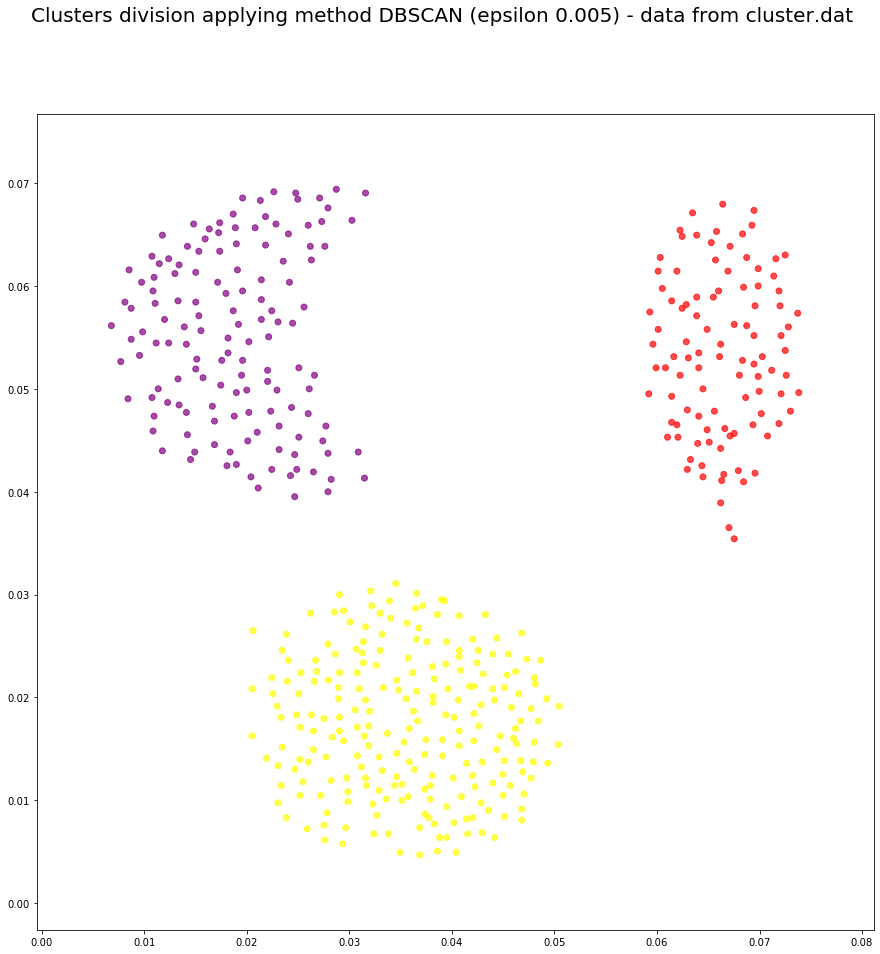

Counter({1: 226, 2: 137, 3: 100})
number of outliers found: 0



In [101]:
callPlot(training,point_labels_train,
     'Clusters division applying method DBSCAN (epsilon ' +str(eps)+ ') - data from cluster.dat')

In [99]:
point_labels_valid = predict(validation, training, clusters_train, point_labels_train, eps)

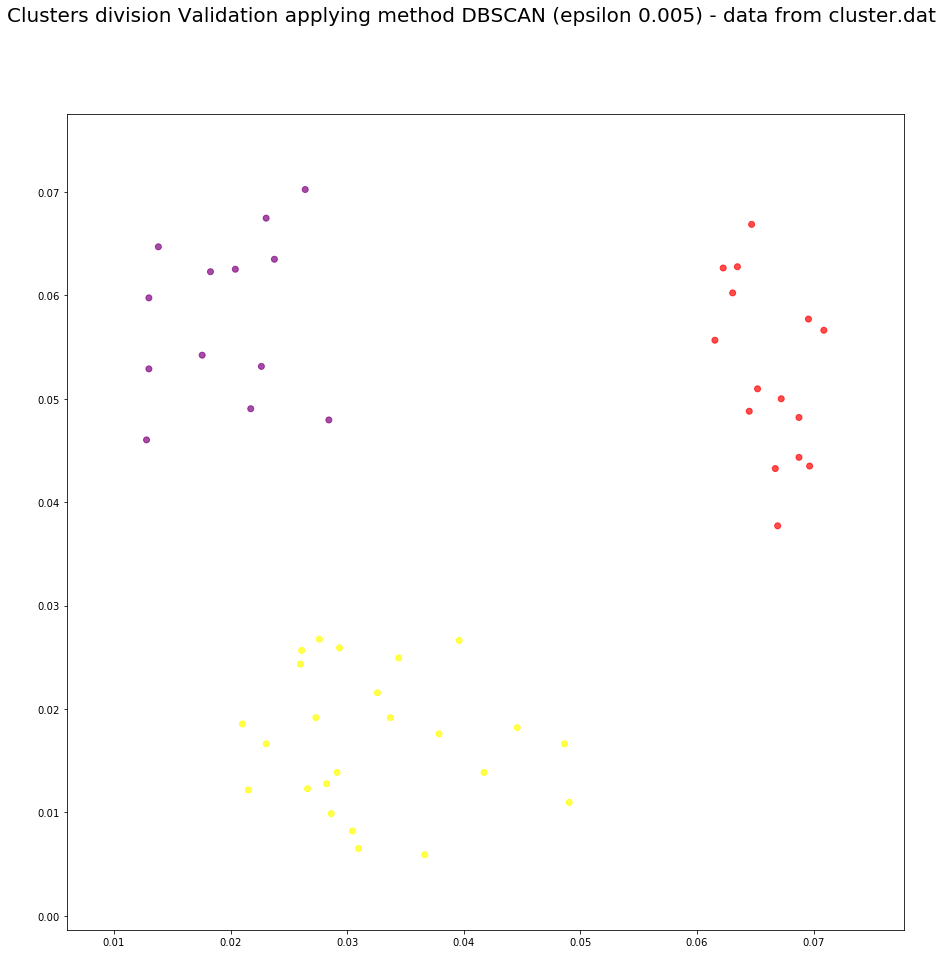

Counter({1: 24, 3: 15, 2: 13})
number of outliers found: 0



In [100]:
callPlot(validation, point_labels_valid,
     'Clusters division Validation applying method DBSCAN (epsilon ' +str(eps)+ ') - data from cluster.dat')

epsilon: 0.001, elbow: 0.33348323895059634, sil: 0.0
epsilon: 0.003, elbow: 0.21691696815755548, sil: 0.1149611542186818
epsilon: 0.006, elbow: 0.044972702849379806, sil: 0.7687992995891719
epsilon: 0.009, elbow: 0.044972702849379806, sil: 0.7687992995891719
epsilon: 0.01, elbow: 0.044972702849379806, sil: 0.7687992995891719
epsilon: 0.02, elbow: 0.189994913565898, sil: 0.6199146916021335
Epsilons:
[0.001, 0.003, 0.006, 0.009, 0.01, 0.02]
Cotovelo:
[0.33348323895059634, 0.21691696815755548, 0.044972702849379806, 0.044972702849379806, 0.044972702849379806, 0.189994913565898]
Coef. Silhueta:
[0.0, 0.1149611542186818, 0.7687992995891719, 0.7687992995891719, 0.7687992995891719, 0.6199146916021335]


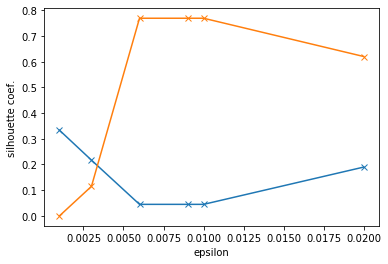

In [98]:
validate(training)